### Instalar pacotes

Este código precisa de algumas bibliotecas para rodar.<br>
Abaixo estão os comando para sua instalação:

### Código Auxiliar

In [6]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [3]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=rgb_id, length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [29]:
def uniform_quant(im, n_colors, middle = False):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    if middle:
        ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + bin_size // 2)
    else:
        ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1

    if middle:
        im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + bin_size // 2)
    else:
        im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [5]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

In [9]:
img = load_sample_image("china.jpg")

In [15]:
new_img = MyImgFormat(*uniform_quant(img, 64)).unpack()

In [30]:
new_img_middle = MyImgFormat(*uniform_quant(img, 64, True)).unpack()

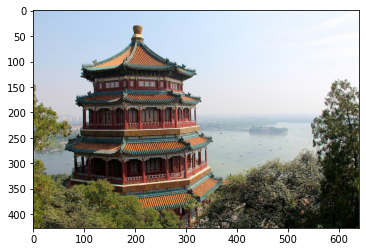

In [17]:
plt.imshow(img)

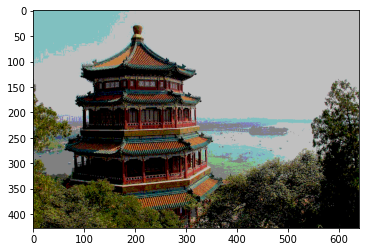

In [18]:
plt.imshow(new_img)

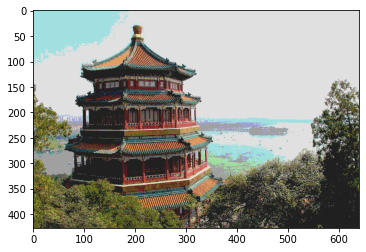

In [31]:
plt.imshow(new_img_middle)

In [33]:
print("Tamanho imagem original: %f"%get_bin_size_kb(img))
print("Tamanho imagem quantizada: %f"%get_bin_size_kb(new_img))
print("Tamanho imagem quantizada para o meio intervalo: %f"%get_bin_size_kb(new_img_middle))

Tamanho imagem original: 820.005000
Tamanho imagem quantizada: 820.005000
Tamanho imagem quantizada para o meio intervalo: 820.005000
